In [125]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
from sklearn import preprocessing as pre

<h2> Here we are getting the data organized based on a specified starting year </h2>

In [126]:
#THIS IS THE YEAR WE WANT TO START AND FINISH CALCULATING THE AVERAGE FROM
#min year is 1980 because the stats are pretty sketchy prior

start_year = 1980
end_year = 2020

In [127]:
all_players_df = pd.read_csv("csv_files/player_stats_"+str(start_year)+".csv")
all_players_df = all_players_df.drop_duplicates('NAME', keep='first')
all_players_df['YEAR']= start_year

for year in range(start_year+1, end_year+1):
    
    #store current year in df
    current_year_players_df = pd.read_csv("csv_files/player_stats_"+str(year)+".csv")

    #since some players were traded during each season their stats are split first showing TOT (total season)
    #and the following rows showing their stats specific for their teams
    #since the total is always first we can drop all duplicates following the first instance (ASSUMING NO PLAYERS HAVE THE SAME NAME)
    current_year_players_df = current_year_players_df.drop_duplicates('NAME', keep='first')
    current_year_players_df['YEAR'] = year
    #appending the current year to all previous years 
    all_players_df = all_players_df.append(current_year_players_df, ignore_index=True)
    
    

all_players_df
    

,NAME,TEAM,POS,AGE,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,YEAR
0,Kareem Abdul-Jabbar*,LAL,C,32,82,,38.3,10.2,16.9,.604,...,2.3,8.5,10.8,4.5,1.0,3.4,3.6,2.6,24.8,1980
1,Tom Abernethy,GSW,PF,25,67,,18.2,2.3,4.7,.481,...,0.9,1.9,2.9,1.3,0.5,0.2,0.6,1.8,5.4,1980
2,Alvan Adams,PHO,C,25,75,,28.9,6.2,11.7,.531,...,2.1,6.0,8.1,4.3,1.4,0.7,2.9,3.2,14.9,1980
3,Tiny Archibald*,BOS,PG,31,80,80,35.8,4.8,9.9,.482,...,0.7,1.7,2.5,8.4,1.3,0.1,3.0,2.7,14.1,1980
4,Dennis Awtrey,CHI,C,31,26,,21.5,1.0,2.3,.450,...,1.1,3.3,4.4,1.5,0.5,0.6,1.0,2.5,3.3,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17099,Thaddeus Young,CHI,PF,31,64,16,24.9,4.2,9.4,.448,...,1.5,3.5,4.9,1.8,1.4,0.4,1.6,2.1,10.3,2020
17100,Trae Young,ATL,PG,21,60,60,35.3,9.1,20.8,.437,...,0.5,3.7,4.3,9.3,1.1,0.1,4.8,1.7,29.6,2020
17101,Cody Zeller,CHO,C,27,58,39,23.1,4.3,8.3,.524,...,2.8,4.3,7.1,1.5,0.7,0.4,1.3,2.4,11.1,2020
17102,Ante Žižić,CLE,C,23,22,0,10.0,1.9,3.3,.569,...,0.8,2.2,3.0,0.3,0.3,0.2,0.5,1.2,4.4,2020


In [128]:
#HERE WE WILL SET CRITERIA FOR OUR DATA BASE AND GET RID OF NANs

#filling null values with 0
all_players_df = all_players_df.fillna(0)

######### UNCOMMENT IF YOU ONLY WANT TO LOOK AT CERTAIN POSITIONS #############
# position = 'C'
# players_df = all_players_df[all_players_df['POS'] == ' ' + position]

######### UNCOMMENT IF YOU ONLY WANT TO LOOK AT CERTAIN TEAM #############
# team = 'TOR'
# players_df = all_players_df[all_players_df['TEAM'] == ' ' + team]

######### UNCOMMENT IF WE WANT ALL PLAYERS #############
players_df = all_players_df

players_df = players_df.reset_index()



<h2> Adding helper methods </h2>
<p> The stats that we want from players to include are pts, reb, ast, stl, blk, tov, pf which are already in this data frame. But to make the most accurate comparisons we are going to want TS% 3PAr and FTr which are not in the df therefore have to be calculated. These helper methods make such calculations </p>

In [129]:
#Helper methods that take in the original data frame and output each stat 
def add_true_shooting(df):
    list_of_TS = []
    #goes through each row of the df and uses data to calculate each stat
    for index, player in df.iterrows():
        #this if statement prevents a divide by zero exception
        if(player['FGA']==0):
            list_of_TS.append(0.00000)
            continue
        ts = player['PTS']/(2*(player['FGA']+(0.44*player['FTA'])))
        #appends this calculated stat to the list 
        list_of_TS.append(ts)
    #adds list to dataframe with proper header    
    df['TS'] = list_of_TS
    return df

#these are methods are similar to the one above just implementing their own stat
def add_3PAr(df):
    list_of_3PAr = []
    for index, player in df.iterrows():
        if(player['FGA']==0):
            list_of_3PAr.append(0.00000)
            continue
        val = player['3PA']/player['FGA']
        list_of_3PAr.append(val)
       
    df['3PAr'] = list_of_3PAr
    return df

def add_FTr(df):
    list_of_FTr = []
    for index, player in df.iterrows():
        if(player['FGA']==0):
            list_of_FTr.append(0.00000)
            continue
        val = player['FTA']/player['FGA']
        list_of_FTr.append(val)
       
    df['FTr'] = list_of_FTr
    return df

def make_per_36(df): 
    for index , player in df.iterrows():
        if player['MP'] == 0:
            continue
        else:
            multiplier = 36 / player['MP']

        df.loc[index,['MP','FG','FGA','3P','3PA','2P','2PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']] *= multiplier
       
        
        if index % int(len(df)*0.25) == 0:
            print(str(index) + " players stats adjusted")
        
    return df
        
    
    

   <h3> Here we are going to add the stats from helper methods if the league tracked those stats at that time</h3>

In [130]:
#adding true shooting 3PAr and FTr to our data frame that is not adjusted per 36
if (start_year >= 1980):
    players_df = add_true_shooting(add_3PAr(add_FTr(players_df )))
else:
    players_df = players_df



<h2> Here we are going to decide if we want the stats adjusted per 36 or not </h2>

In [131]:
#################### Here we change the boolean value ###########
per_36 = True
#################################################################


if per_36: 
    players_df = make_per_36(players_df)
    
    
    


0 players stats adjusted
4276 players stats adjusted
8552 players stats adjusted
12828 players stats adjusted


<h2> Finding averages for player logistics </h2>

<h3> Looking at games played </h3>

Average Games Played is: 54.40358980355472


[]

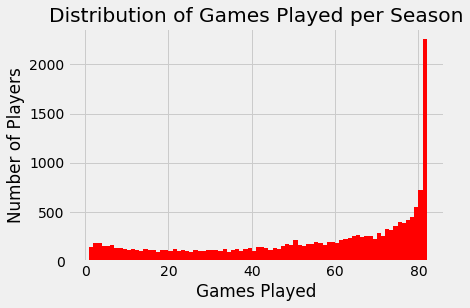

In [132]:
#checking what is the average number of games played 
print("Average Games Played is: " + str(players_df['G'].mean()))

#tor_players_df.hist(column='GP').show()
plt.style.use('fivethirtyeight')

#making the plot 
gamesPlayedHist, g = plt.subplots()

g.hist(players_df['G'],color='red',bins=range(0,83),rwidth=1)
g.set_xlabel("Games Played")
g.set_ylabel("Number of Players")
g.set_title("Distribution of Games Played per Season")
g.plot()

In [133]:
# print(str(len(players_df.loc[players_df['G']== 82])))

# players_df.loc[players_df['G']== 82].head(10)

<h3> Now we are looking at average age </h3>

Average Age is: 26.694808231992518


[]

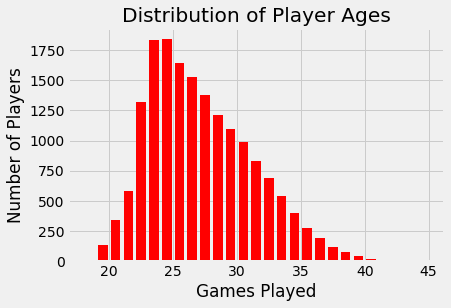

In [134]:
#checking what is the average number of games played 
print("Average Age is: " + str(all_players_df['AGE'].mean()))


plt.style.use('fivethirtyeight')

#making the plot 
gamesPlayedHist, g = plt.subplots()

g.hist(all_players_df['AGE'],color='red',rwidth=0.75, bins=range(18,46))
g.set_xlabel("Games Played")
g.set_ylabel("Number of Players")
g.set_title("Distribution of Player Ages")
g.plot()

<h2> Finding average stats for nba players (no adjustment for minutes) </h2>

<h3> Finding stats that won't be used in comparison </h3>

In [135]:

players_stats_df = players_df[['PTS', 'AST', 'TRB', 'STL','BLK','TS','3PAr', 'FTr','TOV','PF']]
#players_stats_NA_df = players_df[['PTS', 'AST', 'TRB']]

#Taking the mean for each column of our players dataframe
avg_player = players_stats_df.mean()

avg_player

#players_stats_NA_df

PTS     13.677989
AST      3.083297
TRB      6.388198
STL      1.173600
BLK      0.756171
TS       0.508847
3PAr     0.174202
FTr      0.313995
TOV      2.242728
PF       3.832864
dtype: float64

<h3> Finding most average player </h3> 
<p> Here we are going do normalize the dataframes so that the distance measurements will be of equal weights. Then we will find how similar each player's stats are to the average by finding the distance between stat vectors. This measurement will be made using eucliadian distance and cosine similarity </p> 

In [136]:
#Firsr we have to append the mean average player to a dataframe
avg_player_df = pd.DataFrame([avg_player])

df_to_normalize = pd.concat([players_stats_NA_df,avg_player_df])



In [137]:
#now we have to normalize the data 
x = df_to_normalize.values #returns a numpy array
min_max_scaler = pre.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalized_data = pd.DataFrame(x_scaled)

#printing normalized data
#df_normalized_data


In [138]:
#we are going to use test this using euclidian distance and cosine distance 
#I read euclidian is more useful so that will be the baseline 
cos_dist = []
e_dist = []
for i in range(len(players_df)):
    name = players_df.iloc[i]['NAME']
    year = players_df.at[i,'YEAR']
    e_dist.append([name,year, distance.euclidean(df_to_normalize.iloc[-1],df_to_normalize.iloc[i]),i] )
    cos_dist.append([name,year,1 - distance.cosine(df_to_normalize.iloc[-1],df_to_normalize.iloc[i]),i] )
    
e_most_simlar = sorted(e_dist, key=lambda x: x[2])
cos_most_simlar = sorted(cos_dist, key=lambda x: x[2], reverse= True)

#e_most_simlar[-100:-1]

/opt/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [141]:
e_most_simlar[-100:-1]

[['James Harden', 2018, 18.442727102179006, 15713],
 ['Henry Sims', 2013, 18.449554354275747, 13495],
 ['Anthony Miller', 1997, 18.452938750982536, 6214],
 ['Roy Hamilton', 1981, 18.4849902632188, 391],
 ['John Stroeder', 1989, 18.527423136521968, 3123],
 ['Matt Fish', 1997, 18.596559955141704, 6085],
 ['Randy Brown', 2002, 18.611643761628166, 8221],
 ['Stephen Curry', 2016, 18.615116708569243, 14662],
 ['Martynas Andriuškevičius', 2006, 18.66124464196182, 9945],
 ['Ben Moore', 2018, 18.682538046337047, 15867],
 ['Giannis Antetokounmpo', 2019, 18.689636154669007, 16077],
 ['Ron Grandison', 1995, 18.71778054553526, 5261],
 ['Carl Kilpatrick', 1980, 18.722676352134357, 150],
 ['Tim Kempton', 1996, 18.750260497665096, 5726],
 ['Bonzi Wells', 1999, 18.78579231853706, 7247],
 ['Tacko Fall', 2020, 18.871180075204524, 16735],
 ['Jonathan Kerner', 1999, 18.879469137516896, 7040],
 ['Donny Marshall', 2003, 18.931712344028927, 8837],
 ['Darko Miličić', 2013, 18.940089457895034, 13409],
 ['Zach L